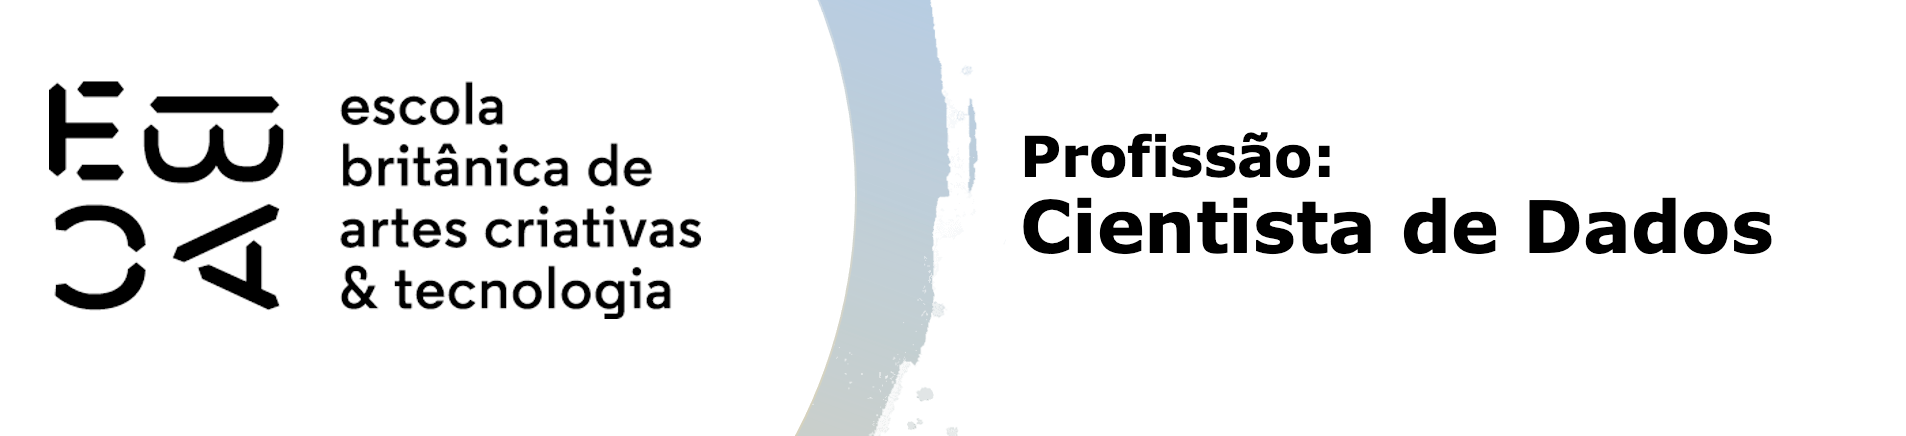

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.model_selection import train_test_split

# Carregar a base
df = pd.read_csv('./Dados/previsao_de_renda_II.csv')

# Substituir missings pela média
# Identificando colunas numéricas para preenchimento
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Separar em base de treino e teste
# Usando random_state para reprodutibilidade
df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)

# Resgatar a melhor versão do modelo (log(renda) ~ demais variáveis exceto data_ref e index)
# Construindo a fórmula dinamicamente
target = 'renda'
ignore_cols = ['data_ref', 'index', target]
predictors = [col for col in df.columns if col not in ignore_cols]
formula = f"np.log({target}) ~ {' + '.join(predictors)}"

# Rodar o modelo na base de treino
model = smf.ols(formula, data=df_train).fit()

# Exibir sumário
print(model.summary())

# Adicionar predições e resíduos ao dataframe de treino para análise
df_train['pred_log_renda'] = model.predict(df_train)
df_train['resid'] = model.resid

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                 1.521e+04
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:34:50   Log-Likelihood:            -7.9815e+05
No. Observations:              562500   AIC:                         1.596e+06
Df Residuals:                  562475   BIC:                         1.597e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

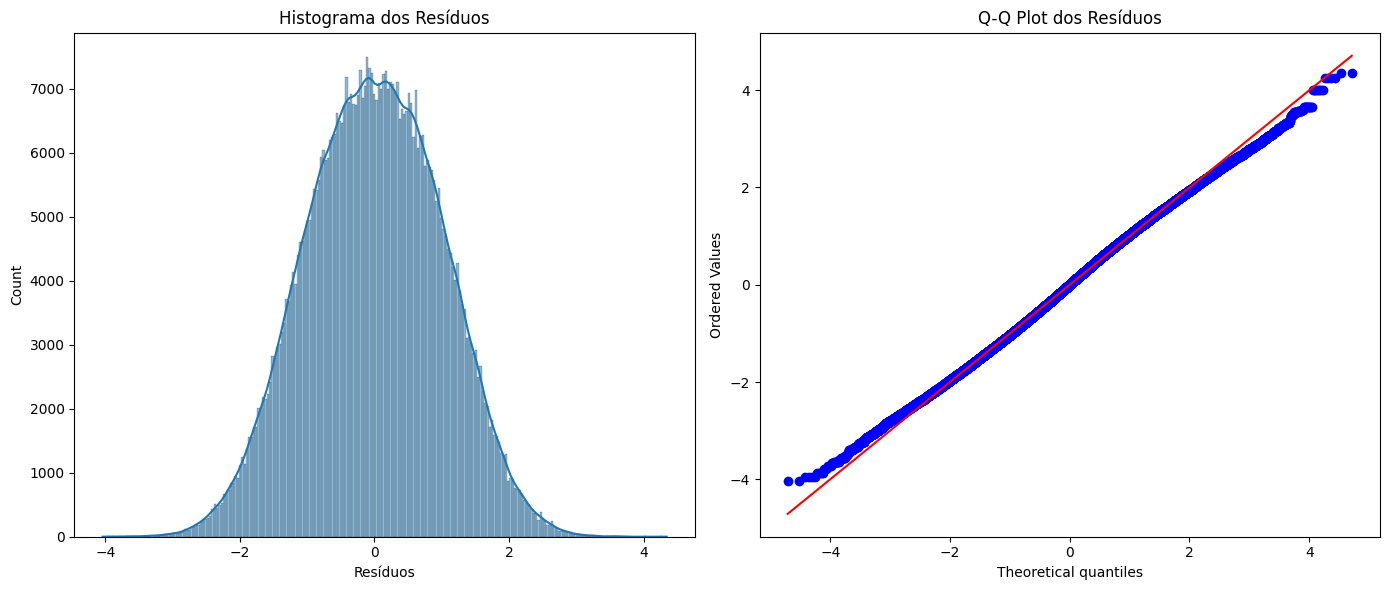

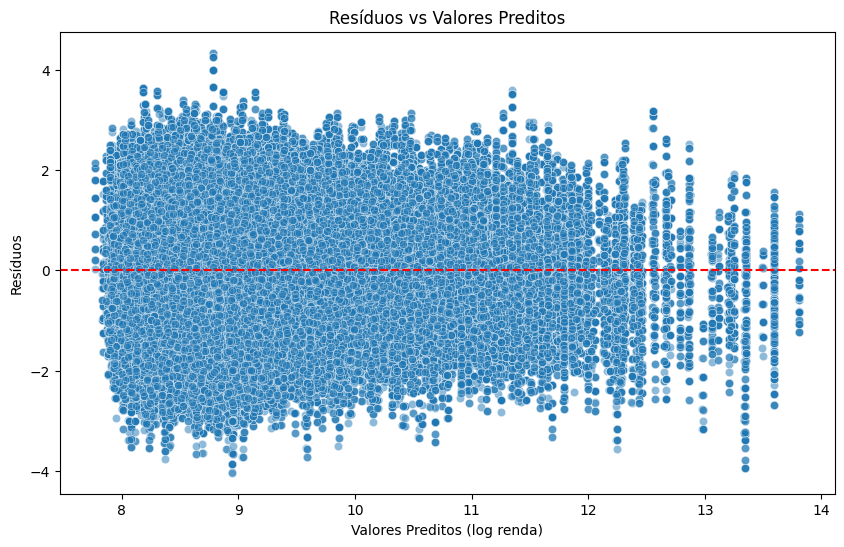

In [2]:
# Análise de Normalidade dos Resíduos
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(model.resid, kde=True)
plt.title('Histograma dos Resíduos')
plt.xlabel('Resíduos')

plt.subplot(1, 2, 2)
import scipy.stats as stats
stats.probplot(model.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot dos Resíduos')

plt.tight_layout()
plt.show()

# Análise de Homocedasticidade (Resíduos vs Preditos)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=model.fittedvalues, y=model.resid, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos (log renda)')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Preditos')
plt.show()

<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Admin\AppData\Local\Temp\ipykernel_248\3217013752.py:44: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sqrt{|Standardized Residuals|}$')


Análise de Resíduos vs Variáveis Explicativas:


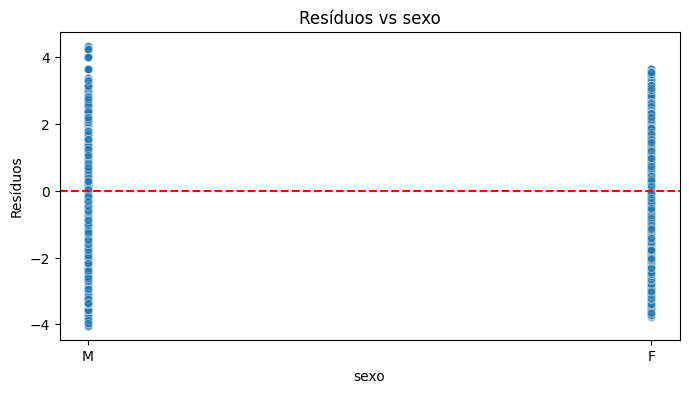

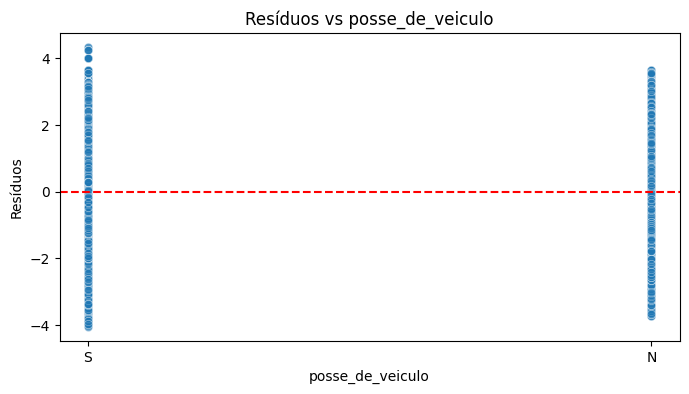

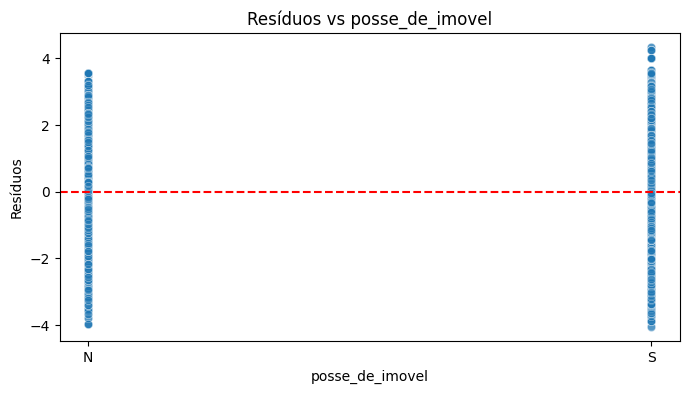

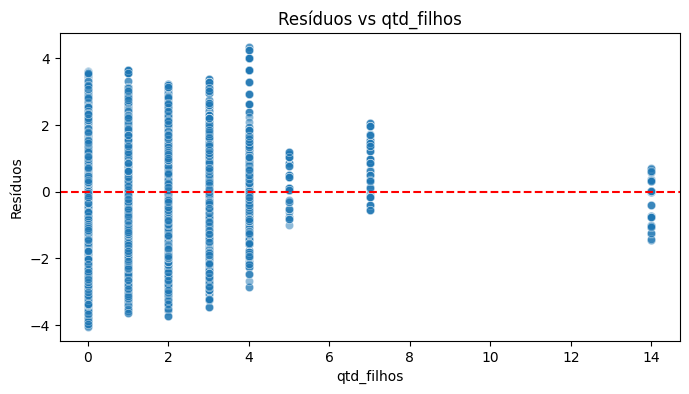

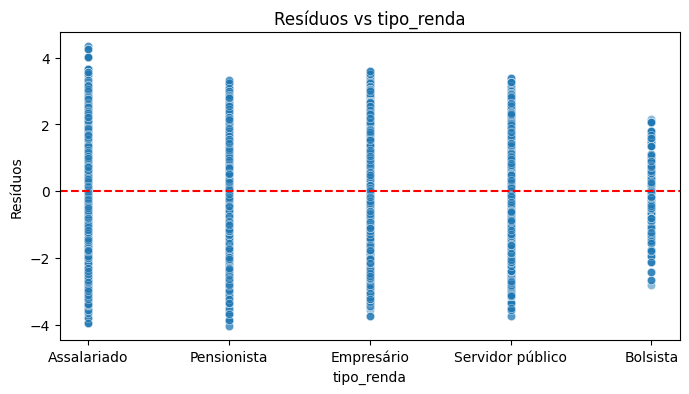

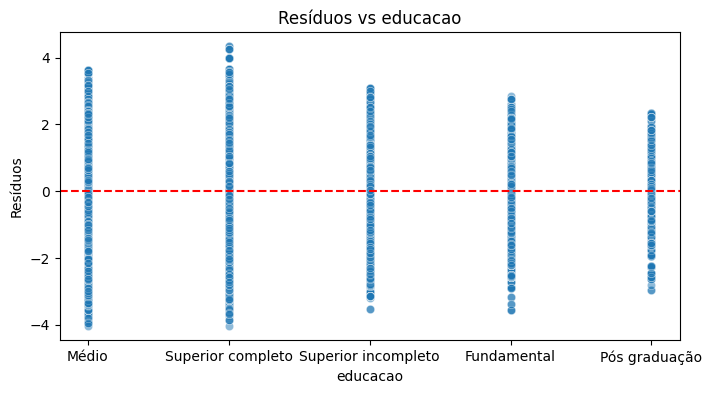

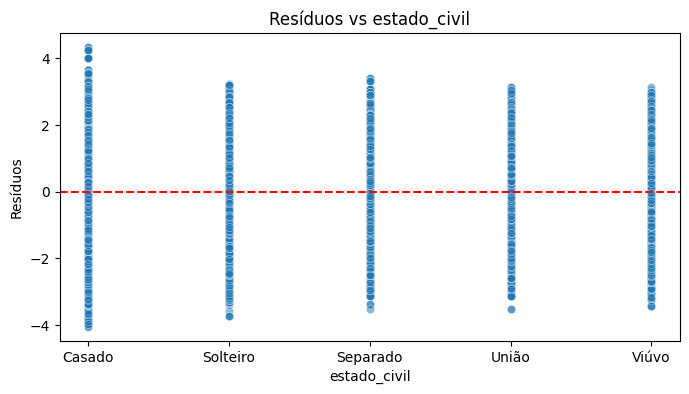

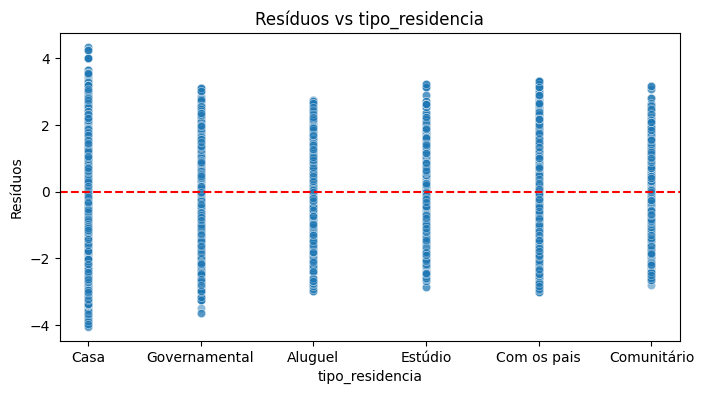

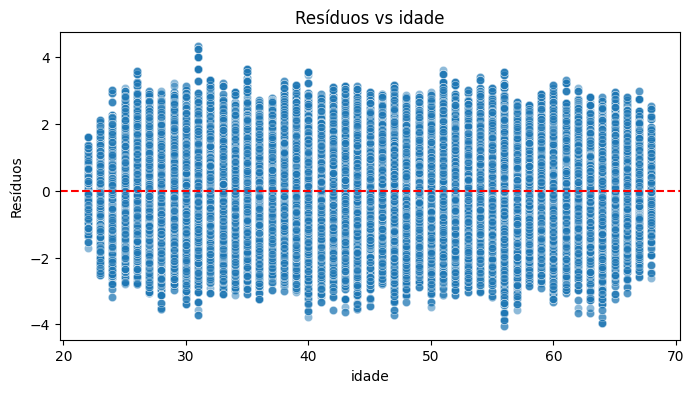

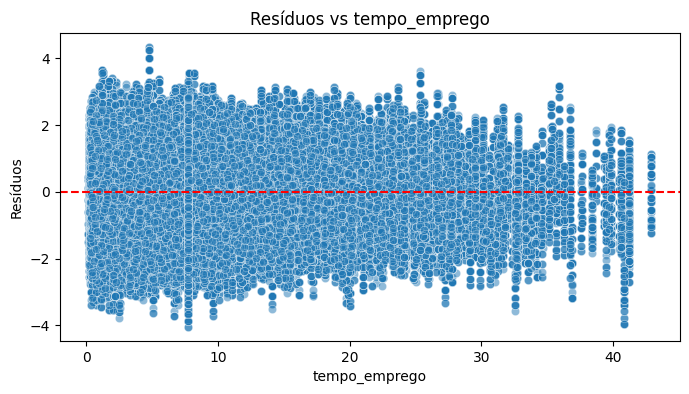

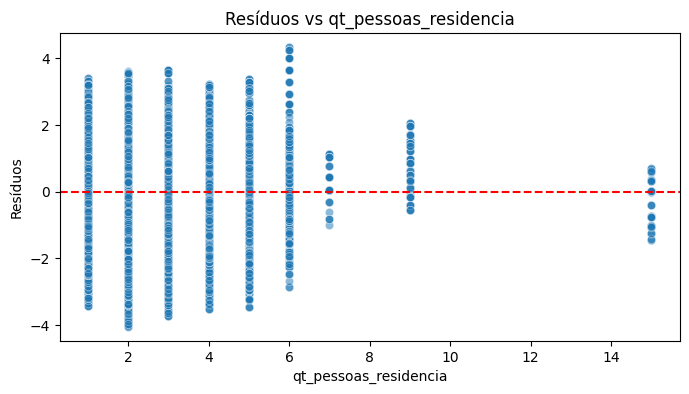

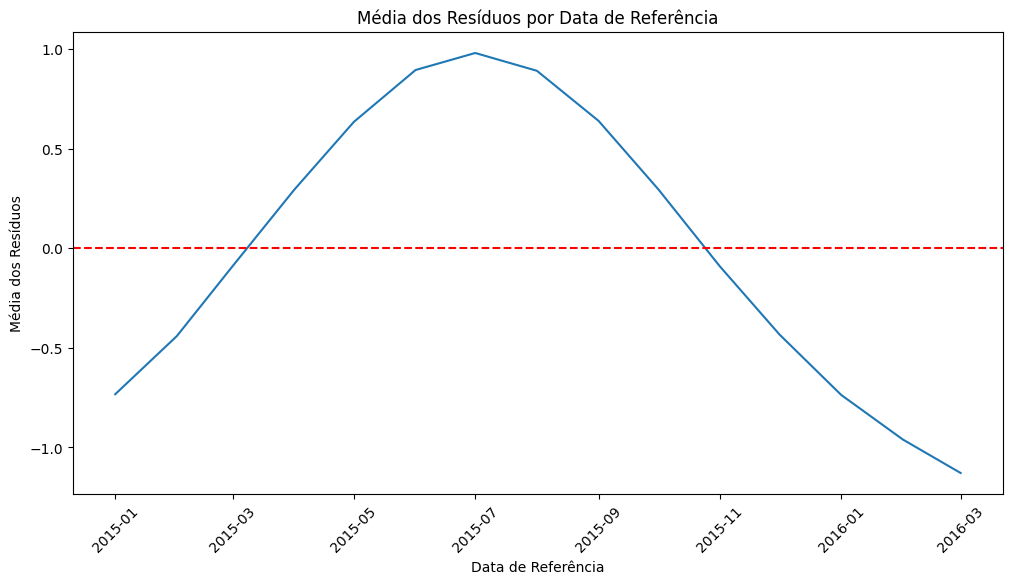

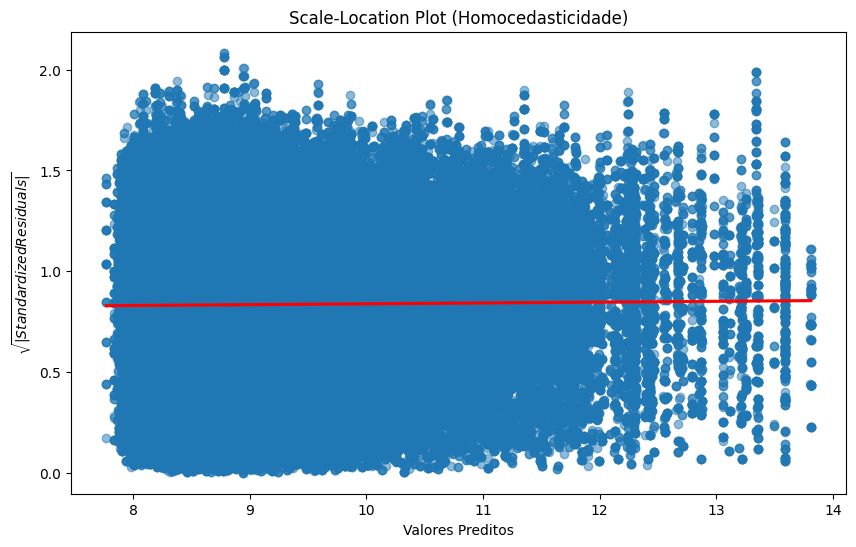

In [3]:
# Avaliação detalhada das suposições

# 1. Padrões dos Resíduos vs Variáveis do Modelo
# Usando a lista de preditores definida anteriormente
print("Análise de Resíduos vs Variáveis Explicativas:")
for var in predictors:
    if var in df_train.columns:
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=df_train[var], y=model.resid, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title(f'Resíduos vs {var}')
        plt.xlabel(var)
        plt.ylabel('Resíduos')
        plt.show()

# 2. Valor médio dos resíduos vs mês de referência
# Garantindo que data_ref seja datetime
if df_train['data_ref'].dtype == 'O':
    df_train['data_ref_dt'] = pd.to_datetime(df_train['data_ref'])
else:
    df_train['data_ref_dt'] = df_train['data_ref']

plt.figure(figsize=(12, 6))
sns.lineplot(x='data_ref_dt', y='resid', data=df_train, estimator='mean', errorbar=None)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Média dos Resíduos por Data de Referência')
plt.xticks(rotation=45)
plt.xlabel('Data de Referência')
plt.ylabel('Média dos Resíduos')
plt.show()

# 3. Variância da variável resposta vs valores previstos (Homocedasticidade)
# Scale-Location Plot: Raiz quadrada dos resíduos padronizados vs Valores ajustados
# Isso ajuda a ver se a variância dos erros muda com o valor predito
plt.figure(figsize=(10, 6))
# Normalizando resíduos para o plot
model_norm_resid = model.get_influence().resid_studentized_internal
model_norm_resid_abs_sqrt = np.sqrt(np.abs(model_norm_resid))

plt.scatter(model.fittedvalues, model_norm_resid_abs_sqrt, alpha=0.5)
sns.regplot(x=model.fittedvalues, y=model_norm_resid_abs_sqrt, scatter=False, ci=False, line_kws={'color': 'red'})
plt.title('Scale-Location Plot (Homocedasticidade)')
plt.xlabel('Valores Preditos')
plt.ylabel('$\sqrt{|Standardized Residuals|}$')
plt.show()

<Axes: xlabel='tempo_emprego', ylabel='None'>

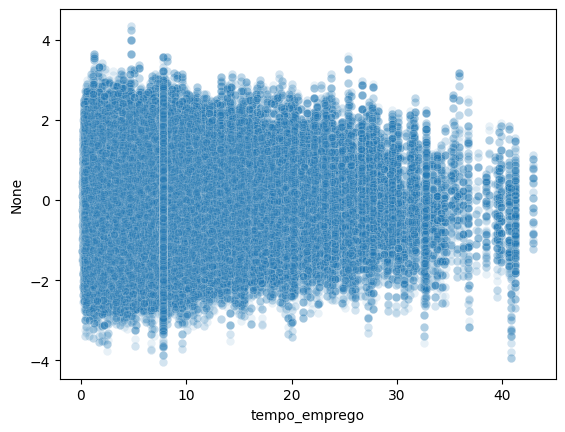

In [4]:
sns.scatterplot(x=df_train['tempo_emprego'], y=model.resid, alpha=0.1)

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

c:\Users\Admin\.ace\ebac\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


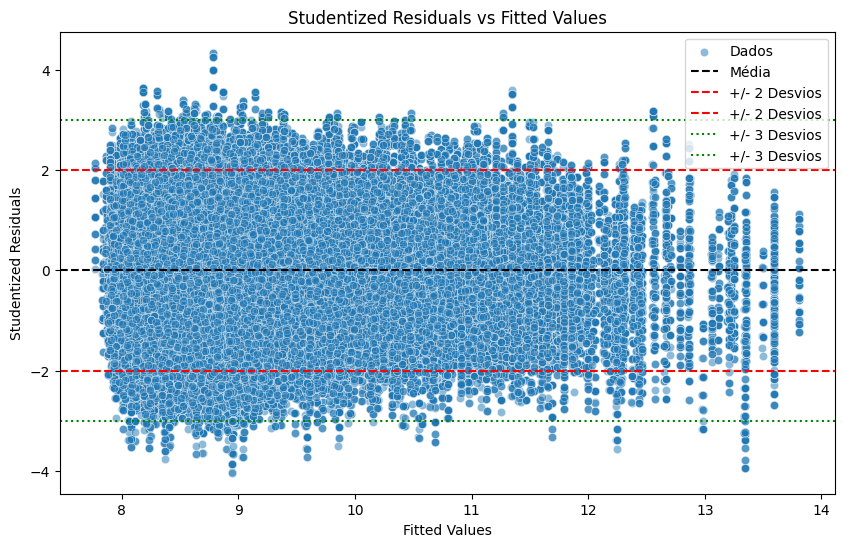

Número de outliers (Studentized Resid > 3): 671
Porcentagem de outliers: 0.12%


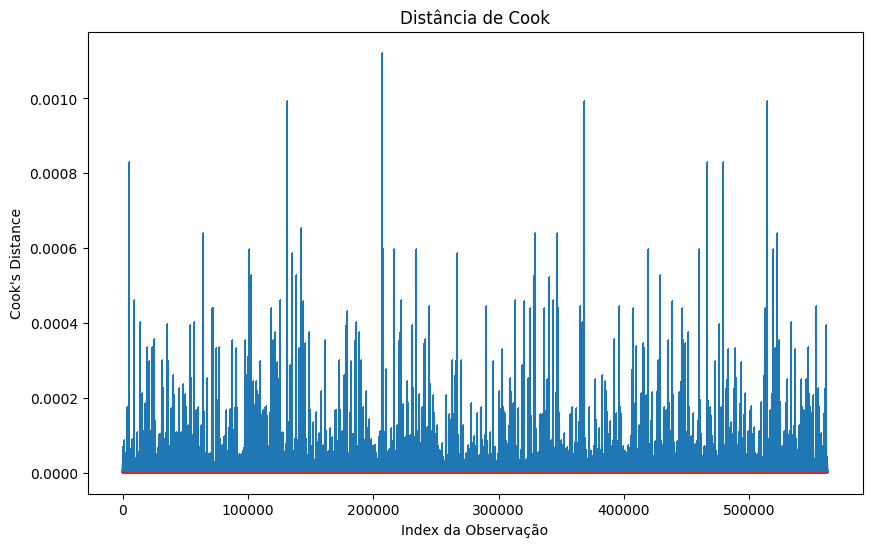

Limiar para Distância de Cook (4/n): 0.00001
Número de pontos influentes: 22775
Valores de 'tempo_emprego' para Pensionistas alterados para -1.


In [5]:
# Studentized Residuals
influence = model.get_influence()
studentized_residuals = influence.resid_studentized_internal

plt.figure(figsize=(10, 6))
sns.scatterplot(x=model.fittedvalues, y=studentized_residuals, alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=2, color='r', linestyle='--')
plt.axhline(y=-2, color='r', linestyle='--')
plt.axhline(y=3, color='g', linestyle=':')
plt.axhline(y=-3, color='g', linestyle=':')
plt.title('Studentized Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Studentized Residuals')
plt.legend(['Dados', 'Média', '+/- 2 Desvios', '+/- 2 Desvios', '+/- 3 Desvios', '+/- 3 Desvios'])
plt.show()

# Identificar outliers (resíduos > 3 ou < -3)
outliers_count = np.sum(np.abs(studentized_residuals) > 3)
print(f"Número de outliers (Studentized Resid > 3): {outliers_count}")
print(f"Porcentagem de outliers: {outliers_count/len(df_train)*100:.2f}%")

# Pontos Influentes (Distância de Cook)
(c, p) = influence.cooks_distance
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.title('Distância de Cook')
plt.xlabel('Index da Observação')
plt.ylabel('Cook\'s Distance')
plt.show()

# Verificar pontos com alta influência (ex: Cook's D > 4/n)
n = len(df_train)
threshold = 4/n
influential_count = np.sum(c > threshold)
print(f"Limiar para Distância de Cook (4/n): {threshold:.5f}")
print(f"Número de pontos influentes: {influential_count}")

# Ajuste nos dados: Pensionistas com tempo_emprego = -1
# Observou-se que pensionistas estavam com valor 0 (ou média), o que pode confundir com quem tem 0 anos de experiência.
# Vamos atribuir -1 para destacar essa categoria.

# Aplicando em treino e teste para manter consistência
# Verificando se a coluna tipo_renda existe
if 'tipo_renda' in df_train.columns:
    df_train.loc[df_train['tipo_renda'] == 'Pensionista', 'tempo_emprego'] = -1
    df_test.loc[df_test['tipo_renda'] == 'Pensionista', 'tempo_emprego'] = -1
    print("Valores de 'tempo_emprego' para Pensionistas alterados para -1.")
else:
    print("Coluna 'tipo_renda' não encontrada.")


## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

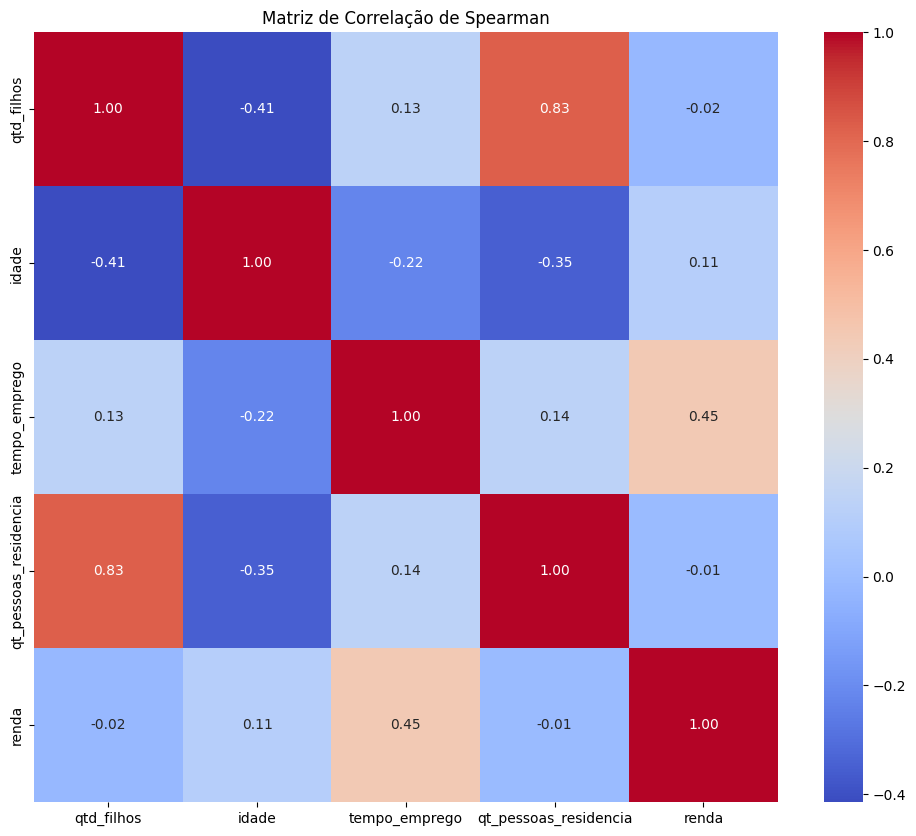

Variance Inflation Factor (VIF):
                             feature          VIF
0                          Intercept  1661.261399
24             qt_pessoas_residencia   299.824575
21                        qtd_filhos   201.288037
13          estado_civil[T.Solteiro]    40.039800
8                  educacao[T.Médio]    21.732189
10     educacao[T.Superior completo]    20.953092
12          estado_civil[T.Separado]    20.672277
15             estado_civil[T.Viúvo]    15.869743
16           tipo_residencia[T.Casa]     6.712443
11   educacao[T.Superior incompleto]     4.364247
17    tipo_residencia[T.Com os pais]     4.014774
20  tipo_residencia[T.Governamental]     3.184303
22                             idade     2.161623
6          tipo_renda[T.Pensionista]     1.827355
19        tipo_residencia[T.Estúdio]     1.526357
18    tipo_residencia[T.Comunitário]     1.320794
1                          sexo[T.M]     1.227149
2              posse_de_veiculo[T.S]     1.198494
23               

In [6]:
# Matriz de correlação de Spearman
# Selecionar apenas colunas numéricas relevantes
numeric_cols_corr = df_train.select_dtypes(include=[np.number]).columns
cols_to_drop = ['pred_log_renda', 'resid', 'index', 'Unnamed: 0'] # Remover colunas auxiliares se existirem
numeric_df = df_train[numeric_cols_corr].drop(columns=[c for c in cols_to_drop if c in numeric_cols_corr], errors='ignore')

corr_spearman = numeric_df.corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação de Spearman')
plt.show()

# VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Usando a matriz de design do modelo ajustado (já inclui intercepto e dummies)
exog = model.model.exog
vif_data = pd.DataFrame()
vif_data["feature"] = model.model.exog_names
vif_data["VIF"] = [variance_inflation_factor(exog, i) for i in range(exog.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data.sort_values('VIF', ascending=False))

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [7]:

# Identificando variáveis com P-valor alto (> 0.05)
high_p_vars = model.pvalues[model.pvalues > 0.05].sort_values(ascending=False)
print("Variáveis com P-valor > 0.05 (candidatas a remoção):")
print(high_p_vars)

# Ajuste do Modelo: Remover variáveis não significativas
# Vamos remover as variáveis simples e também tratar as dummies
import re

current_predictors = predictors.copy()
vars_removed = []

for var, pval in high_p_vars.items():
    # Se a variável é um termo simples (está em predictors)
    if var in current_predictors:
        print(f"Removendo variável: {var} (p-valor={pval:.4f})")
        current_predictors.remove(var)
        vars_removed.append(var)
    # Se for uma dummy (ex: estado_civil[T.Uniao]), tenta identificar a variável original
    else:
        # Padrão comum do statsmodels: NomeVariavel[T.Nivel]
        match = re.match(r"(.+)\[T\..+\]", var)
        if match:
            base_var = match.group(1)
            if base_var in current_predictors:
                print(f"Removendo variável base: {base_var} devido a dummy {var} (p-valor={pval:.4f})")
                current_predictors.remove(base_var)
                vars_removed.append(base_var)

if not vars_removed:
    print("Nenhuma variável foi removida automaticamente.")
else:
    print(f"Variáveis removidas: {vars_removed}")

new_formula = f"np.log({target}) ~ {' + '.join(current_predictors)}"
print(f"Nova fórmula: {new_formula}")

# Treinando o Modelo Ajustado
model_adjusted = smf.ols(new_formula, data=df_train).fit()
print(model_adjusted.summary())

# Comparação de Desempenho na Base de Teste
from sklearn.metrics import r2_score, mean_squared_error

# Predições
y_true = np.log(df_test['renda'])
y_pred_orig = model.predict(df_test)
y_pred_adj = model_adjusted.predict(df_test)

# Métricas
r2_orig = r2_score(y_true, y_pred_orig)
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred_orig))

r2_adj = r2_score(y_true, y_pred_adj)
rmse_adj = np.sqrt(mean_squared_error(y_true, y_pred_adj))

# Dataframe de Comparação
comparison = pd.DataFrame({
    'Métrica': ['R² (Teste)', 'RMSE (Teste)', 'AIC (Treino)'],
    'Original': [r2_orig, rmse_orig, model.aic],
    'Ajustado': [r2_adj, rmse_adj, model_adjusted.aic]
})

print("\nComparação de Desempenho:")
print(comparison)

Variáveis com P-valor > 0.05 (candidatas a remoção):
estado_civil[T.União]    0.774796
dtype: float64
Removendo variável base: estado_civil devido a dummy estado_civil[T.União] (p-valor=0.7748)
Variáveis removidas: ['estado_civil']
Nova fórmula: np.log(renda) ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia
                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 1.824e+04
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:36:41   Log-Likelihood:            -7.9822e+05
No. Observations:              562500   AIC:                         1.596e+06
Df Residuals:                  562479   